<a href="https://colab.research.google.com/github/V-Nayak/Projects/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To detect hate speech in tweets via classifying racist or sexist tweets from other tweets.

In [3]:
# loading the libraries

import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train=pd.read_csv("/content/drive/MyDrive/ML Projects/TSA/train_E6oV3lV.csv")
test=pd.read_csv("/content/drive/MyDrive/ML Projects/TSA/test_tweets_anuFYb8.csv")

In [6]:
train.describe

<bound method NDFrame.describe of           id  label  \
0          1      0   
1          2      0   
2          3      0   
3          4      0   
4          5      0   
...      ...    ...   
31957  31958      0   
31958  31959      0   
31959  31960      0   
31960  31961      1   
31961  31962      0   

                                                                                                                                     tweet  
0                                    @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run  
1               @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked  
2                                                                                                                      bihday your majesty  
3                                                   #model   i love u take with u all the time in urð±!!! ðððð
ð

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [8]:
train.shape, test.shape

((31962, 3), (17197, 2))

train data has labeled 1 for sexist and racist tweets from other tweets(0)

Data inspection 

In [9]:
# lets check for Non racist or Non sexist tweets.
train[train['label']== 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


In [10]:
# lets check for racist or sexist tweets

train[train['label']== 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
77,78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
82,83,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
111,112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦


In [11]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

NOw here we gone check the distributio of lenght of the tweets(in terms of words)

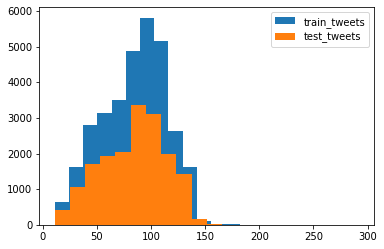

In [12]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()
plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

In [13]:
# Combining the data

combi = train.append(test, ignore_index =True)
combi.shape

(49159, 3)

In [14]:
# to remove unwanted text patterns

def remove_pattern(input_txt, pattern):
    r=re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '',input_txt)
    return input_txt

# here we will create new column by removing the user name/handler of Tweeter

combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [15]:
# Removing the punctuations, Numbers and special characters

combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")
combi.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


In [16]:
# Removing Short words(<=3)
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [20]:
# text Normalisation(ntlks PorterStemmer() function) after tokenisation(splitting a string text into tokens) the tweets

# tokenization
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()


0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [ ]:
pip install nltk

In [32]:
# nomrlize the tokenzised tweets

from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x:[stemmer.stem(i) for i in x])

In [35]:
# stiching together the tokenized word(using nltk MosesDetokenizer function)

for i in range(len(tokenized_tweet)): 
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combi['tidy_tweet'] = tokenized_tweet

## **Story Genaration and Visualization from tweets**

In [ ]:
!pip install WordCloud

In [ ]:
pip install tweepy

In [ ]:
pip install textbook

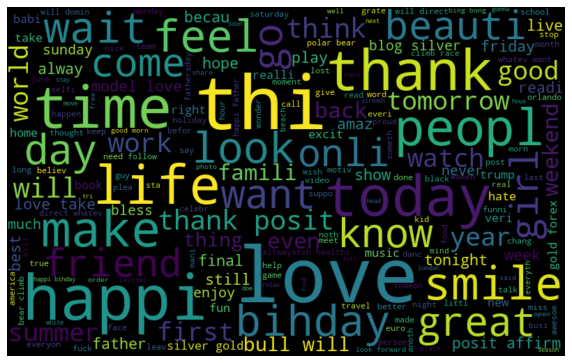

In [57]:
# visualise all the words using world cloud plot

all_words =' '.join([text for text in combi['tidy_tweet']]) 
from wordcloud import WordCloud
wordcloud = WordCloud(width=800,height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

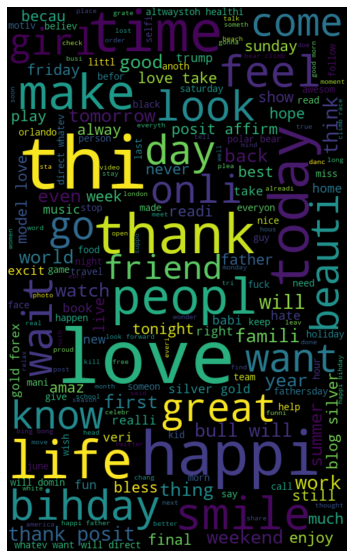

In [59]:
# visualise the words in Non Racist or Sexist 

Normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]]) 
 
wordcloud = WordCloud(width=500,height=800, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(7,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


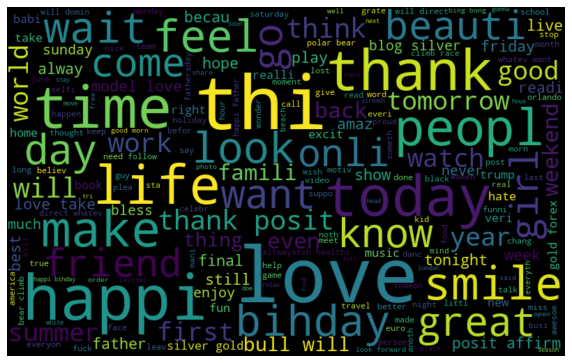

In [63]:
# visualise the words in Racist or Sexist 

Negative_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] ==1]]) 
 
wordcloud = WordCloud(width=800,height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()